In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Transfer learning: What, why, and when?

In [ ]:
'''
Transfer learning is a great feautre of the deep learning community
and it allows you to leverage all of the hard work
that other people have done building great models and training models with lots of data.

* What "transfer learning" means.
- The idea of transfer learning is that you train up this network on this data set,
  and then you take this network and you transfer it.
- You apply this trained network to a different problem, to different data sets, different images.
- Transferring a trained model to a different data set or a different problem.
- Now you cannot simply just copy and paste everything in the model and expect it to work immediately.
- That's because the nature of the problem is different.
- So transfer learning does require a little bit of extra training.
- And then there's a couple of ways to do this to fine tune the model so that it's going to work for this particular problem,
  which is slightly different from the problem that you trained the model on.

- One common way to implement transfer learning is to freeze part of the model.
- For example, you can freeze all of these layers. So basically all of the layers except for the output layer.
- And then you would do some retraining with your data.
- So you continue training the data or the model based on your data, which is different from the data that the model was originally trained on.
- But notice you are not training the entire model.
 -So a lot of the parameters in the model are fixed, they are frozen and you're only training the output layer.
 - This is called "fine tuning" the model (freezing all of these layers).

- Another way is to fine tune the entire model.
- We're not freezing any of the weights, any of the layers or anything. So we're allowing the entire model to be retrained.
- But the model doesn't need to be trained from scratch.
- Because we already have a model that has learned lots of low level image statistics, features like edges and curves and things like that.
- So there's actually a lot less for the model to learn.
- That's the idea of fine tuing the entire model.
- This procedure is also called "trained weight initialization", because instead of initializing this model to have weights that are just purely random numbers, the weights here are initialized to be the weights from a model that is already trained on a slightly different problem.
- But hopefully it's similar enough that the weight. Initialization makes sense.
- Transfer learning is not always going to work and is always a great solution.
- There are many instances where transfer learning actually does not make sense and is probably only going to impair your performance and slow down learning.

* Why transfer learning is useful in DL.
- Transfer learning allows you to
  1) leverage HUGE datasets and existing (source) models to solve new problems.
  2) fine-tune existing trained models to your unique data.
  3) deploy models quickly and with limited computational and data resources.
  4) "stand on the shoulders of giants."

* When to use transfer learning.
- your problem is similar to a problem that someone else has solved (and published their model).
- the model was trained on a lot more data than what you have.
- the model is deep; shallow models are less likely to transfer well unless the target data are very similar.

* How to use trasfer learning.
- Decide whether it is appropriate: (1) Do you have insufficient complex data and (2) does a well-trained model exist? (well trained model using data that are fairly similar to the kind of data you have)
- Decide which (if any) layers to freeze: The closer your data to the source model, the more layers you can freeze.
  (What is common is to freeze all of the convolutional layers and to fine tune either all of the final feedforward layers or
   maybe just the very last output layer.)
- Fine-tune the target model as much as possible.
- Inspect the model and results carefully; never assume that transfer will be successful.

'''

# Transfer learning: MNIST -> FMNIST

## Import and process the data

In [ ]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels, normalize, reshape
labels_tensor = torch.tensor(data[:,0]).long()
data = data[:,1:]
dataNorm = data / np.max(data)
dataNorm_tensor = torch.tensor(dataNorm.reshape(dataNorm.shape[0],1,28,28)).float()

# split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataNorm_tensor, labels_tensor, test_size=.1)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# translate into DataLoader objects
batchsize=32
numbers_train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
numbers_test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [ ]:
### FMNIST data

# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(.5,.5)
])

# import the data and apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# translate into dataloader objects
batchsize=32
fashion_train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
fashion_test_loader = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26421880/26421880 [00:03<00:00, 8010533.48it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 137640.41it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2529627.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14973839.80it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Create the DL model

In [ ]:
def createTheMNISTNet(print_toggle=False):

    class mnistNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            # --------------------- convolution layers ---------------------- #
            self.conv1 = nn.Conv2d(1,10, kernel_size=5, stride=1, padding=1)
            # size: np.floor((28 + 2*1 - 5)/1) + 1 = 26 / 2 = 13 (maxpool)

            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            # size: np.floor((13 + 2*1 - 5)/1) + 1 = 11 / 2 = 5 (maxpool)

            # compute the number of units in FClayer (number of outputs of conv2)
            expectSize = int(5**2)*20

            # --------------------- linear decision layers ---------------------- #
            # fully-connected layer
            self.fc1 = nn.Linear(expectSize, 50)

            # output layer
            self.out = nn.Linear(50, 10)

            # toggle for printing out tensor sizes during forward prop
            self.print = print_toggle

        def forward(self, x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1: {x.shape}') if self.print else None

            # convolution  -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2: {x.shape}') if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {x.shape}')

            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x

    net = mnistNet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.005)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [ ]:
# input the network and the number of epochs to train

def function2trainTheModel(net, lossfunc, optimizer, train_loader, test_loader, numepochs=10):

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Train the source model on numbers and show the results

In [ ]:
# create a new model
numberNet, lossfunc, optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc, testAcc, losses, numberNet = function2trainTheModel(numberNet, lossfunc, optimizer, numbers_train_loader, numbers_test_loader, 5)

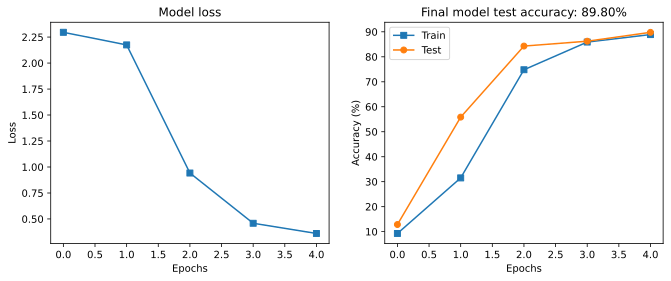

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Test the model on the fashion data

In [ ]:
# test the model with fashion data

X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 5.09%


## Fine-tune the model with one training batch

In [ ]:
# create the target model
fashionNet, lossfunc, optimizer = createTheMNISTNet()

# then replace all the weights in TARGET model from SOURCE model!!!!
for target, source in zip(fashionNet.named_parameters(), numberNet.named_parameters()):
    target[1].data = copy.deepcopy( source[1].data )

In [ ]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )

In [ ]:
# now re-train the network on the fashion data
trainAcc, testAcc, losses, fashionNet = function2trainTheModel(
    fashionNet, lossfunc, optimizer, fashion_train_loader, fashion_test_loader, 1
)

In [ ]:
print(f'fashionNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'fashionNet TEST accuracy: {testAcc[-1]:.2f}%')

fashionNet TRAIN accuracy: 69.78%
fashionNet TEST accuracy: 77.04%


## Comparison with fashionNet from scratch

In [ ]:
# create a fresh model
fashionNet, lossfunc, optimizer = createTheMNISTNet()

# and train it on fashion data
trainAcc, testAcc, losses, fashionNet = function2trainTheModel(fashionNet, lossfunc, optimizer, fashion_train_loader, fashion_test_loader, 5)

In [ ]:
print(f'fashionNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'fashionNet TEST accuracy: {testAcc[-1]:.2f}%')

fashionNet TRAIN accuracy: 83.97%
fashionNet TEST accuracy: 81.49%


# Letters to numbers

In [ ]:
'''
How to freeze convolution layers, and fine-tune only the categorization layers in re-training.
'''

In [ ]:
'''
- Import both 'letters' and 'digits'
- Train on letters for 5 epochs.
- Transfer the model to digits.
- (1) Re-train the entire model, and (2) Fine-tune only the categorization layers. Train only one epoch.
'''

## Import the data

In [ ]:
# download the datasets
letterdata = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)
numberdata = torchvision.datasets.EMNIST(root='emnist', split='digits', download=True)

100%|██████████| 561753746/561753746 [00:05<00:00, 97100116.60it/s] 


Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [ ]:
# transformations on the letter data

# remove N/A class
letterCategories = letterdata.classes[1:]
labels = copy.deepcopy(letterdata.targets)-1

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0], 1, 28, 28]).float()
letterImages / torch.max(letterImages)

# split the images and convert to dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(letterImages, labels, test_size=.1)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize=32
letters_train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
letters_test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [ ]:
# transformations on the letter data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0], 1, 28, 28]).float()
numberImages / torch.max(numberImages)

# split the images and convert to dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize=32
number_train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
number_test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

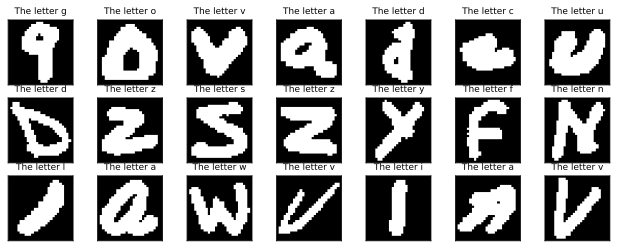

In [ ]:
# visualize some letters
fig, axs = plt.subplots(3,7,figsize=(11,4))

# gt a batch of letter data
X, y = next(iter(letters_train_loader))

for i, ax in enumerate(axs.flatten()):

    # extract the image and its target letter
    I = np.squeeze(X[i,:,:])
    letter = letterCategories[y[i]]

    # visualize
    ax.imshow(I.T, cmap='gray', vmin=0, vmax=1)
    ax.set_title('The letter %s' % letter, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

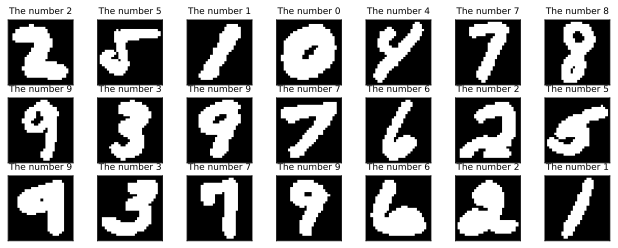

In [ ]:
# visualize some numbers
fig, axs = plt.subplots(3,7,figsize=(11,4))

# get a batch of number data
X, y = next(iter(number_train_loader))

for i, ax in enumerate(axs.flatten()):

    # extract the image and its target number
    I = np.squeeze(X[i,:,:])
    number = y[i].item()

    # visualize
    ax.imshow(I.T, cmap='gray', vmin=0, vmax=1)
    ax.set_title('The number %s' % number, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Create the DL model

In [ ]:
def makeTheNet(print_toggle=False):

    class emnistnet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            # print toggle
            self.print = print_toggle

            # ---------------- feature map layers ---------------- #
            # first convolution layer
            self.conv1 = nn.Conv2d(1,6,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(6)
            # output size: (28 + 2*1 - 3)/1 + 1 = 28 / 2 = 14 (maxpool)

            # second convolution layer
            self.conv2 = nn.Conv2d(6,6,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)
            # output size: (14 + 2*1 - 3)/1 + 1 = 14 / 2 = 7 (maxpool)

            # ---------------- linear decision layers ---------------- #
            self.fc1 = nn.Linear(6*7*7, 50)
            self.fc2 = nn.Linear(50, 26)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm - > relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'First block: {list(x.shape)}')

            # second block: convolution -> maxpool -> batchnorm - > relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'Second block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    net = emnistnet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [ ]:
def function2trainTheModel(net, lossfunc, optimizer, train_loader, test_loader, numepochs=10):

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []
        batchErr = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchErr.append( 100 * torch.mean((torch.argmax(yHat, axis=1)!=y).float()).item() )

        trainErr[epochi] = np.mean(batchErr)
        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))

        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)
            loss = lossfunc(yHat, y)

        testLoss[epochi] = loss.item()
        testErr[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1)!=y).float()).item()

    return trainLoss, testLoss, trainErr, testErr, net

## Train the model on the letters

In [ ]:
# create a new model
letterNet, lossfunc, optimizer = makeTheNet()

trainLoss, testLoss, trainErr, testErr, letterNet = function2trainTheModel(
    letterNet, lossfunc, optimizer, letters_train_loader, letters_test_loader, 5
)

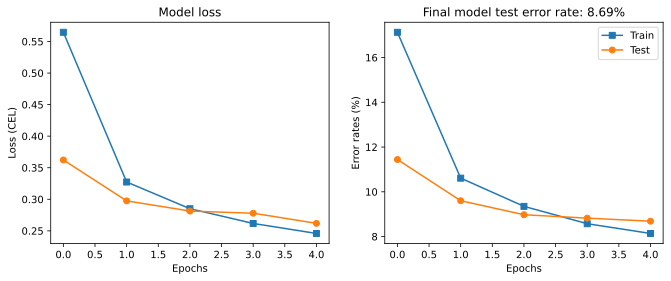

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr, 's-', label='Train')
ax[1].plot(testErr, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

## Test the model on the number data

In [ ]:
# extract X, y from NUMBER test loader
X, y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

letterNet.eval()
yHat = letterNet(X)

# the test
numberAcc = 100 * torch.mean((torch.argmax(yHat, axis=1)!=y).float())

print(f'letterNet error rate on NUMBER data: {numberAcc:.2f}%')

letterNet error rate on NUMBER data: 96.90%


## Fine-tune the model with one training batch

In [ ]:
# create the target model
numberNet, lossfunc, optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target, source in zip(numberNet.named_parameters(), letterNet.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

In [ ]:
# check out the network
print(numberNet)
print()

# and the final layer
print(numberNet.fc2)

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50, 10)

# and check it again
print()
print(numberNet)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)

Linear(in_features=50, out_features=26, bias=True)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
# now re-train the network on the numbers data
trainLoss, testLoss, trainErr, testErr, numberNet = function2trainTheModel(
    numberNet, lossfunc, optimizer, number_train_loader, number_test_loader, 1
)

In [ ]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.42%
numberNet TEST error rate: 1.19%


## Try again, only train output layer

In [ ]:
# create the target model
numberNet2, lossfunc, optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target, source in zip(numberNet2.named_parameters(), letterNet.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

# adjust number of output units
numberNet2.fc2 = nn.Linear(50,10)

# freeze convolution and batch-norm layers
for p in numberNet2.named_parameters():
    if ('conv' in p[0]) or ('bnorm' in p[0]):
        p[1].requires_grad=False

In [ ]:
# now re-train the network on the numbers data
trainLoss, testLoss, trainErr, testErr, numberNet2 = function2trainTheModel(
    numberNet2, lossfunc, optimizer, number_train_loader, number_test_loader, 1
)

In [ ]:
print(f'numberNet2 TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet2 TEST error rate: {testErr[-1]:.2f}%')

numberNet2 TRAIN error rate: 2.77%
numberNet2 TEST error rate: 1.33%


# Famous CNN architectures

In [ ]:
'''
Pretrained models via PyTorch
- Torchvision.models
'''

# Transfer learning with ResNet-18

In [ ]:
'''
* How to download a pretrained model and adjust it for classification.
* See the huge benefit from downloading pretrained models!
'''

In [ ]:
''' The plan
1) Import the image data.
2) Download a pretrained resnet18.
3) Freeze the model.
4) Replace the final layer.
5) Fine-tune only the output layer.
'''

## Import a dataset

In [ ]:
# Note: resnet is trained for images in a specific range (NOT [-1. 1]).
#           That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([
    T.ToTensor(), # normalizes to range [0, 1]
    T.Normalize(mean=[0.485, 0.456, .0406], std=[0.229, 0.224, 0.225])
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset = torchvision.datasets.STL10(root='./data', download=True, split='test', transform=transform)

# transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=256)

100%|██████████| 2640397119/2640397119 [02:48<00:00, 15623915.69it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print(trainset.data.shape)
print(testset.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data), np.max(testset.data)) )

# the unique categories
print('\nData categories:')
print(trainset.classes)

# Need to be 3x96x96
# Need to be normalized
X, y = next(iter(train_loader))

print('\nData shapes (train/test):')
print(X.data.shape)

print('\nData value range:')
print( (torch.min(X.data), torch.max(X.data)))

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(4.2640))


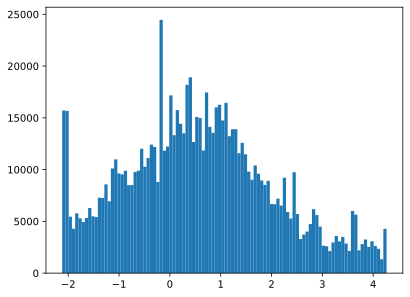

In [ ]:
# histogram of the data
plt.hist(X.data.numpy().flatten(), 100);

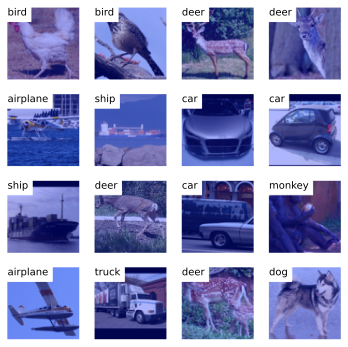

In [ ]:
# inspect a few random images
fig, axs = plt.subplots(4,4,figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic - np.min(pic) # undo normalization
    pic = pic / np.max(pic)

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(0,0,label, ha='left', va='top', color='k', backgroundcolor='w')
    ax.axis('off')

# plt.tight_layout()
plt.show()

## Import and inspect the resnet model

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

# let's inspect this network
resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(resnet.to(device), (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [ ]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad=False

    # python note: the above operation can be implemented in-line:
    # p.requires_grad_(False)

In [ ]:
# change the final layer
resnet.fc = nn.Linear(512, 10)

In [ ]:
# push the modle to the GPU (if using)
resnet.to(device);

## Train the model

In [ ]:
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=.001, momentum=.9)

numepochs = 10

# intialize losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epochi in range(numepochs):

    resnet.train()
    batchLoss = []
    batchAcc = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        yHat = resnet(X)
        loss = lossfunc(yHat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    resnet.eval()
    batchLoss = []
    batchAcc = []
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfunc(yHat, y)

        batchLoss.append(loss.item())
        batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi] = np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi + 1} / {numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1 / 10. Test accuracy = 73.45%
Finished epoch 2 / 10. Test accuracy = 76.71%
Finished epoch 3 / 10. Test accuracy = 77.19%
Finished epoch 4 / 10. Test accuracy = 77.99%
Finished epoch 5 / 10. Test accuracy = 77.49%
Finished epoch 6 / 10. Test accuracy = 77.76%
Finished epoch 7 / 10. Test accuracy = 78.22%
Finished epoch 8 / 10. Test accuracy = 78.72%
Finished epoch 9 / 10. Test accuracy = 78.54%
Finished epoch 10 / 10. Test accuracy = 78.80%


## Visualize the performance

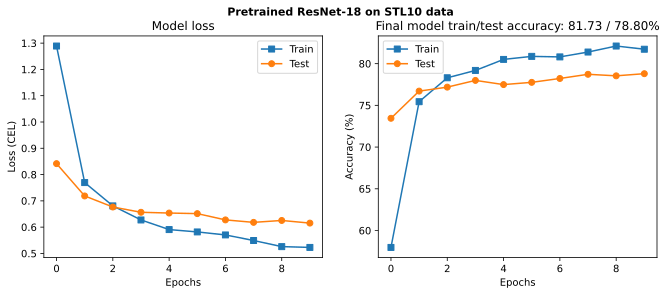

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f} / {testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data', fontweight='bold', fontsize=11)
plt.show()

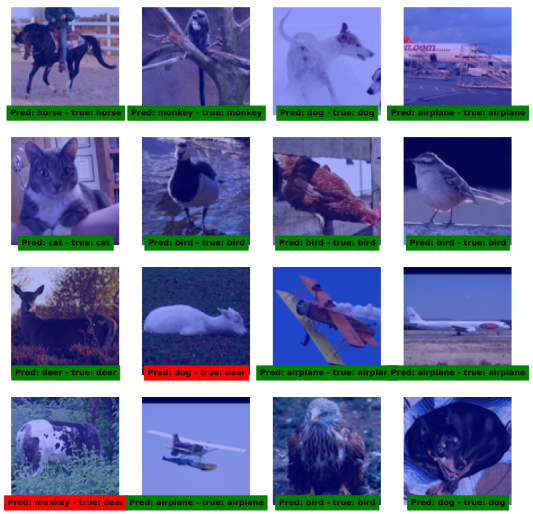

In [ ]:
# inspect a few random images
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

resnet.eval()
predictions = torch.argmax(resnet(X), axis=1)

fig, axs = plt.subplots(4,4,figsize=(9,9))

for (i, ax) in enumerate(axs.flatten()):

    pic = X.data[i].cpu().numpy().transpose((1,2,0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    ax.imshow(pic)

    label = trainset.classes[predictions[i]]
    truec = trainset.classes[y[i]]
    title = f'Pred: {label} - true: {truec}'

    titlecolor = 'g' if truec==label else 'r'
    ax.text(48,90, title, ha='center', va='top', fontweight='bold', color='k', backgroundcolor=titlecolor, fontsize=8)
    ax.axis('off')

plt.show()

## Additional explorations

In [ ]:
# 1) Try re-downloading the resnet18, unfreeze the layers, and re-run. This means you'll be fine-tuning the entire
#    network instead of only the final prediction layer.
#
# 2) Download an untrained resnet18. This is simply the architecture with random weights (you'll still need to replace
#    the final layer so it has 10 outputs). Train this model; how is the performance?
#
# 3) I used SGD as the backprop method. Try re-running the analysis using Adam. Does this help or hurt the train and
#    test performance?
#
# 4) ~80% accuracy is pretty decent considering we didn't do anything to optimize the model. Looking through the model
#    metaparameters, what are some things you would try to change if you wanted to boost performance?
#
# 5) You've seen earlier in the course that data normalization is important. This is particularly so for pretrained
#    networks, because the weights are tuned to specific numerical ranges. But how important is the *exact* numerical
#    range? To find out, re-run the code but remove the normalization transform. Thus, the images now will be in the
#    range [0,1], which is overlapping with but smaller than (and non-negative) the range that the network is trained on.
#

# VGG-16

## Import a dataset

100%|██████████| 2640397119/2640397119 [02:25<00:00, 18197788.91it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Data shape (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


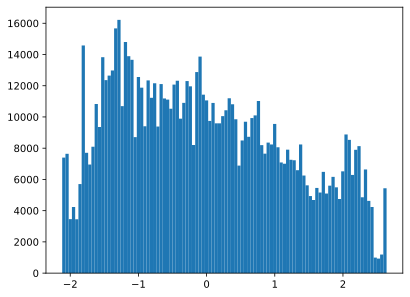

In [ ]:
# transformations
transform = T.Compose([
    T.ToTensor(), # normalizes to range [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # further normalization
])

# import the data and apply the tranform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset = torchvision.datasets.STL10(root='./data', download=True, split='test', transform=transform)

# transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=256)

# check out the shape of the datasets
print('Data shapes (train/test):')
print(trainset.data.shape)
print(testset.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data), np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print(trainset.classes)

X, y = next(iter(train_loader))
print('\nData shape (train/test):')
print(X.data.shape)

print('\nData value range:')
print( (torch.min(X.data), torch.max(X.data)) )

# histogram of the data
plt.hist(X.data.numpy().flatten(), 100);

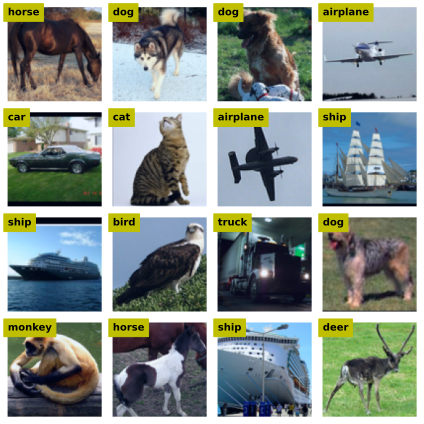

In [ ]:
# inspect a few random images
fig, axs = plt.subplots(4,4, figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    label = trainset.classes[y[i]]

    ax.imshow(pic)
    ax.text(0,0,label, ha='left', va='top', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Import and inspect the VGG-16 model

In [ ]:
vggnet = torchvision.models.vgg16(pretrained=True)

# let's inspect this network
vggnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vggnet.to(device), (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers (final layer changed later)
for p in vggnet.parameters():
    p.requires_grad = False

In [ ]:
# change the final layer (this time soft-coded!)
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features, 10)

# push the model to th GPU
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the model

In [ ]:
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggnet.parameters(), lr=.001, momentum=.9)

numepochs = 10

trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epochi in range(numepochs):

    vggnet.train()
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        yHat = vggnet(X)
        loss = lossfunc(yHat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    vggnet.eval()
    batchAcc = []
    batchLoss = []

    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = vggnet(X)
            loss = lossfunc(yHat, y)

        batchLoss.append(loss.item())
        batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi] = np.mean(batchAcc)

    print(f'Finished epoch {epochi+1} / {numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1 / 10. Test accuracy = 90.91%
Finished epoch 2 / 10. Test accuracy = 91.05%
Finished epoch 3 / 10. Test accuracy = 91.32%
Finished epoch 4 / 10. Test accuracy = 91.47%
Finished epoch 5 / 10. Test accuracy = 91.28%
Finished epoch 6 / 10. Test accuracy = 91.36%
Finished epoch 7 / 10. Test accuracy = 91.78%
Finished epoch 8 / 10. Test accuracy = 91.55%
Finished epoch 9 / 10. Test accuracy = 91.64%
Finished epoch 10 / 10. Test accuracy = 91.50%


## Visualize the performance

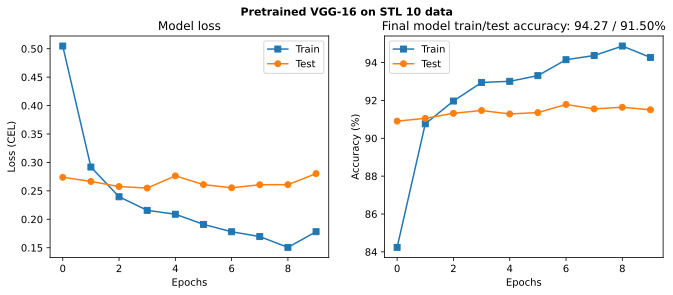

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f} / {testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL 10 data', fontweight='bold', fontsize=11)
plt.show()

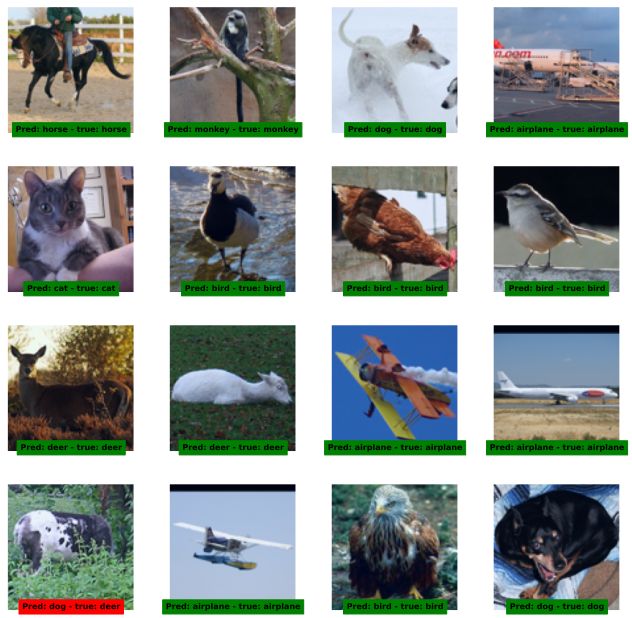

In [ ]:
# inspect a few random images

X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

vggnet.eval()
predictions = torch.argmax( vggnet(X), axis=1 )

fig, axs = plt.subplots(4,4, figsize=(9,9))

for (i, ax) in enumerate(axs.flatten()):
    pic = X.data[i].cpu().numpy().transpose((1,2,0))
    pic = pic - np.min(pic)
    pic = pic / np.max(pic)

    ax.imshow(pic)

    label = trainset.classes[predictions[i]]
    truec = trainset.classes[y[i]]
    title = f'Pred: {label} - true: {truec}'

    titlecolor = 'g' if truec==label else 'r'
    ax.text(48,90, title, ha='center', va='top', fontweight='bold', color='k', backgroundcolor=titlecolor, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Pretraining with autoencoders

In [ ]:
'''
* How to "pretrain" the lower layers of a network.
* Pretraining is not trivially always better!

* How to pretrain using autoencoders
1) Build an autoencoder for your data.
2) Train the autoencoder to satisfactory performance.
3) Create a new model that has the same architecture as the encoder, and copy the weights from the autoencoder.
4) Add linear layers to the end of the new model.
5) Train the transferred model to classify the data.

* Pros and cons of autoencoder pretraining
- Optimize the model for your data (as opposed to using an existing model, e.g., AlexNet).
- Useful with limited data (can re-use data without overfitting).
- Can save computation time if using an existing model.

- Autoencoders do not necessarily identify the features that are relevant for classification.
  Not every learned parameter transfer.
  (The goal of an autoencoder is completely different from the goal of a classifier model.
  An autoencoder simply wants to reconstruct the image based on a lower dimensional representation,
  whereas the classifier model wants to categorize the model as being in one of several discrete categories.
  So that means that what is the optimal set of weights and filters for an autoencoder are not necessarily going to be
  the optimal set of filters for a classificaion problem.)

'''

## Import a dataset

In [ ]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=.5),
    T.Normalize(.5, .5),
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valtest = torchvision.datasets.FashionMNIST(root='./data',train=False, download=True, transform=transform)

# split the valtest into two separate sets
rand_idx = np.random.permutation(10000)
valset = Subset(valtest, rand_idx[:6000])
testset = Subset(valtest, rand_idx[6000:])

# transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
val_loader = DataLoader(valset, batch_size=len(valset))
test_loader = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26421880/26421880 [00:02<00:00, 11608673.12it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 192452.21it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3679419.33it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21592276.99it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



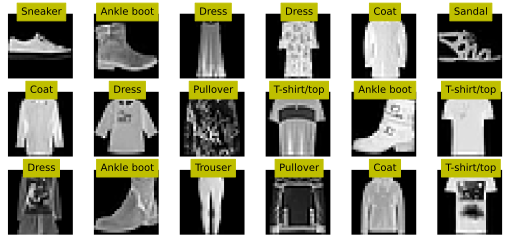

In [ ]:
# inspect a few random images
X, y = next(iter(test_loader))

fig, axs = plt.subplots(3,6,figsize=(9,4))

for (i, ax) in enumerate(axs.flatten()):

    pic = torch.squeeze(X.data[i])
    pic = pic/2 + .5

    label = trainset.classes[y[i]]

    ax.imshow(pic, cmap='gray')
    ax.text(14,0, label, ha='center', color='k', backgroundcolor='y')
    ax.axis('off')

plt.show()

## Create the autoencoder model

In [ ]:
def makeTheAENet(print_toggle=False):

    class aenet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ### ------------------ encoder layers ------------------ ###
            # first convolution layer
            self.enc_conv1 = nn.Conv2d(1,16,3,padding=1, stride=2)
            # output size: (28 + 2*1 - 3)/2 + 1 = 14

            # second convolution layer
            self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)
            # output size: (14 + 2*1 - 3)/2 + 1 = 7

            ### ------------------ decoder layers ------------------ ###
            # first convolution layer
            self.dec_conv1 = nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2)
            # output size: ?

            # second convolution layer
            self.dec_conv2 = nn.ConvTranspose2d(16, 1, 4, padding=1, stride=2)
            # output size: ?

        def forward(self, x):

            if self.print: print(f'Input: {x.shape}')

            # first encoder layer
            x = F.leaky_relu(self.enc_conv1(x))
            if self.print: print(f'First encoder layer: {x.shape}')

            # second encoder layer
            x = F.leaky_relu(self.enc_conv2(x))
            if self.print: print(f'Second encoder layer: {x.shape}')

            # first decoder layer
            x = F.leaky_relu(self.dec_conv1(x))
            if self.print: print(f'First decoder layer: {x.shape}')

            # second decoder layer
            x = F.leaky_relu(self.dec_conv2(x))
            if self.print: print(f'Second decoder layer: {x.shape}')

            return x

    net = aenet(print_toggle)
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

In [ ]:
# test the model with one batch
tmpnet, lossfunc, optimizer = makeTheAENet(True)

X, y = next(iter(train_loader))
yHat = tmpnet(X)

# check size of output
print('Output size:')
print(yHat.shape)

# compute the loss
loss = lossfunc(yHat, X)
print('\nLoss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
First encoder layer: torch.Size([32, 16, 14, 14])
Second encoder layer: torch.Size([32, 32, 7, 7])
First decoder layer: torch.Size([32, 16, 14, 14])
Second decoder layer: torch.Size([32, 1, 28, 28])
Output size:
torch.Size([32, 1, 28, 28])

Loss:
tensor(0.7028, grad_fn=<MseLossBackward0>)


## Create a function that trains the AUTOENCODER model

In [ ]:
def function2trainTheAEModel():

    numepochs = 10

    net, lossfunc, optimizer = makeTheAENet()

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()

        batchLoss = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(val_loader))

        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)
            loss = lossfunc(yHat, X)

        valLoss[epochi] = loss.item()

    return trainLoss, valLoss, net

## Run the model and show the results!

In [ ]:
# ~3 minutes with 10 epochs on GPU
trainLoss, valLoss, aenet = function2trainTheAEModel()

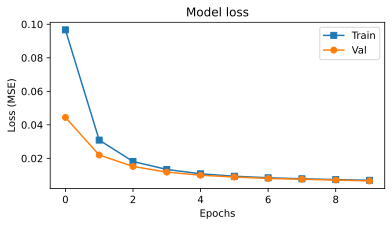

In [ ]:
fig = plt.figure(figsize=(6,3))

plt.plot(trainLoss, 's-', label='Train')
plt.plot(valLoss, 'o-', label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

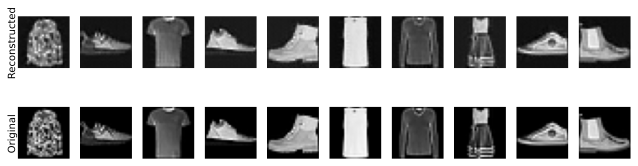

In [ ]:
# show some random examples

X, y = next(iter(val_loader))

aenet.cpu()
aenet.eval()
yHat = aenet(X)

fig, axs = plt.subplots(2,10,figsize=(11,3))

for i in range(10):
    pic = yHat[i,0,:,:].detach()
    pic = pic/2 + .5
    axs[0,i].imshow(pic, cmap='gray')
    axs[0,i].axis('off')

    pic = X[i,0,:,:].detach()
    pic = pic/2 + .5
    axs[1,i].imshow(pic, cmap='gray')
    axs[1,i].axis('off')

    if i == 0:
        axs[0,0].text(-6,14, 'Reconstructed', rotation=90, va='center')
        axs[1,0].text(-6,14, 'Original', rotation=90, va='center')

plt.show()

## Now create a ne model that does classification

In [ ]:
def makeTheClassNet(print_toggle=False):

    class cnnnet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ### ------------------ encoder layers ------------------ ###
            # first convolution layer
            self.enc_conv1 = nn.Conv2d(1,16,3,padding=1, stride=2)
            # output size: (28 + 2*1 - 3)/2 + 1 = 14

            # second convolution layer
            self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2)
            # output size: (14 + 2*1 - 3)/2 + 1 = 7

            ### ------------------ linear layers ------------------ ###
            self.fc1 = nn.Linear(32*7*7, 50)
            self.fc2 = nn.Linear(50, 10)

        def forward(self, x):

            if self.print: print(f'Input: {x.shape}')

            # first encoder layer
            x = F.leaky_relu(self.enc_conv1(x))
            if self.print: print(f'First encoder layer: {x.shape}')

            # second encoder layer
            x = F.leaky_relu(self.enc_conv2(x))
            if self.print: print(f'Second encoder layer: {x.shape}')

            # reshape to linear
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Post-convolution vectorized: {x.shape}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            if self.print: print(f'First linear layer: {x.shape}')

            x = self.fc2(x)
            if self.print: print(f'Second linear layer: {x.shape}')

            return x

    net = cnnnet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

In [ ]:
# test the model with one batch
tmpnet, lossfunc, optimizer = makeTheClassNet(True)

X, y = next(iter(train_loader))
yHat = tmpnet(X)

print('\nOutput size:')
print(yHat.shape)

loss = lossfunc(yHat, y)
print('\nLoss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
First encoder layer: torch.Size([32, 16, 14, 14])
Second encoder layer: torch.Size([32, 32, 7, 7])
Post-convolution vectorized: torch.Size([32, 1568])
First linear layer: torch.Size([32, 50])
Second linear layer: torch.Size([32, 10])

Output size:
torch.Size([32, 10])

Loss:
tensor(2.3132, grad_fn=<NllLossBackward0>)


## Now we need another function to train the classifier

In [ ]:
def function2trainTheClassModel(net, lossfunc, optimizer):

    numepochs = 10

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = np.mean(batchAcc)

        net.eval()
        X, y = next(iter(val_loader))

        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)
            loss = lossfunc(yHat, y)

        valLoss[epochi] = loss.item()
        valAcc[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

    return trainLoss, valLoss, trainAcc, valAcc, net

In [ ]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet, lossfunc, optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive, valLossNaive, trainAccNaive, valAccNaive, naivenet = function2trainTheClassModel(
    naivenet, lossfunc, optimizer)

In [ ]:
# evaluate on the test set
naivenet.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = naivenet(X)
    loss = lossfunc(yHat, y)

testLossNaive = loss.item()
testAccNaive = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

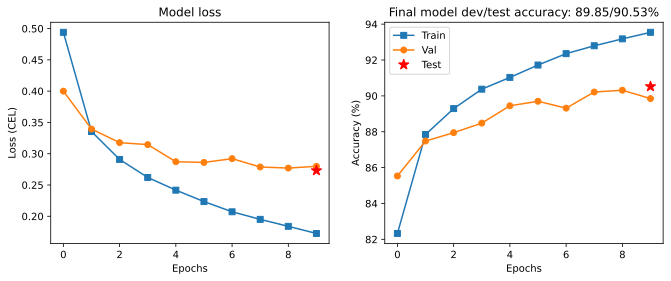

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(valLossNaive,'o-',label='Val')
ax[0].plot(len(valLossNaive)-1,testLossNaive,'r*',markersize=11,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(valAccNaive,'o-',label='Val')
ax[1].plot(len(valAccNaive)-1,testAccNaive,'r*',markersize=11,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {valAccNaive[-1]:.2f}/{testAccNaive:.2f}%')
ax[1].legend()

plt.show()

## Build a new model but replace the convolution layers with AE layer

In [ ]:
pretrainNet, lossfunc, optimizer = makeTheClassNet()

#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target, source in zip(pretrainNet.named_parameters(), aenet.named_parameters()):
    print('PRETRAIN: ' + target[0] + ' AENET: ' + source[0])
    if 'enc' in target[0]:
        target[1].data = copy.deepcopy( source[1].data )

PRETRAIN: enc_conv1.weight AENET: enc_conv1.weight
PRETRAIN: enc_conv1.bias AENET: enc_conv1.bias
PRETRAIN: enc_conv2.weight AENET: enc_conv2.weight
PRETRAIN: enc_conv2.bias AENET: enc_conv2.bias
PRETRAIN: fc1.weight AENET: dec_conv1.weight
PRETRAIN: fc1.bias AENET: dec_conv1.bias
PRETRAIN: fc2.weight AENET: dec_conv2.weight
PRETRAIN: fc2.bias AENET: dec_conv2.bias


In [ ]:
# train the pretrained model

# training
trainLossPre, valLossPre, trainAccPre, valAccPre, pretrainNet = function2trainTheClassModel(
    pretrainNet, lossfunc, optimizer
)

In [ ]:
# evaluate on the test set
pretrainNet.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = pretrainNet(X)
    loss = lossfunc(yHat, y)

testLossPre = loss.item()
testAccPre = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

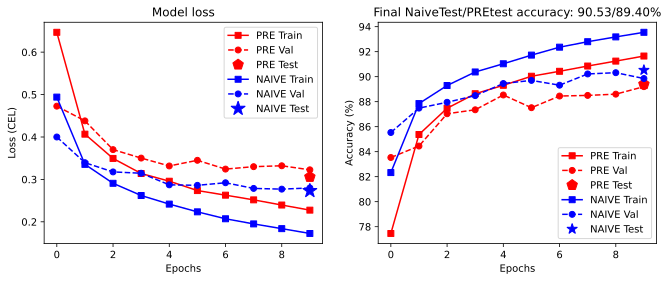

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(valLossPre,'ro--',label='PRE Val')
ax[0].plot(len(valLossPre)-1,testLossPre,'rp',markersize=11,label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(valLossNaive,'bo--',label='NAIVE Val')
ax[0].plot(len(valLossNaive)-1,testLossNaive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(valAccPre,'ro--',label='PRE Val')
ax[1].plot(len(valAccPre)-1,testAccPre,'rp',markersize=11,label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(valAccNaive,'bo--',label='NAIVE Val')
ax[1].plot(len(valAccNaive)-1,testAccNaive,'b*',markersize=11,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive:.2f}/{testAccPre:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
''' How this model with the pre-trained weights compares to the model, the naive model without any pre-training.
The naive model we trained completely from scratch. The Pre-trained model actually started off with the weights from the autoencoder.
So what we would like to see and what you might have expected is that Pre-trained model accuracies should be higher than
Naive models. But actually what you see opposite pattern.
The naive model consistently outperforms the pre-trained model by 1 or 2% generally in that range.
Why is that the case?
The autoencoder is learning features of the data that are not necessarily optimal for categorization.
So when the model simply learns to categorize right off the bat, it's looking for different kinds of features in the data,
different kinds of image statistics compared to the model that was pre-trained with weights that are designed to reduce the
dimensionality of the images and then expand them back out.
'''

## Perhaps they differ by feature map activation?

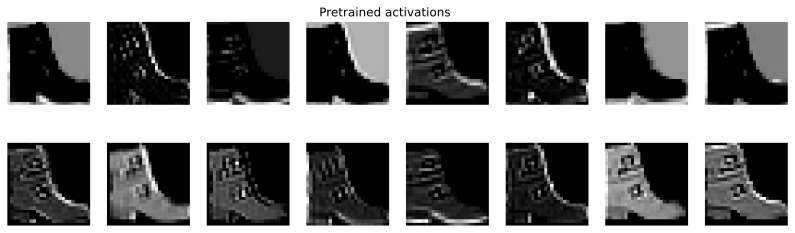

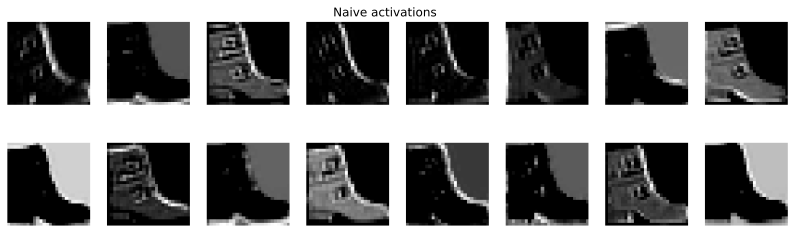

In [ ]:
# grab one image
x = X[10,:,:,:].view(1,1,28,28)

# compute the activations of the first layer (excluding the bias b/c this is simply a constant)
layer1ActPre = F.relu( F.conv2d(x,pretrainNet.enc_conv1.weight) )
layer1ActNai = F.relu( F.conv2d(x,naivenet.enc_conv1.weight) )

## show the feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained activations',y=.9)
plt.show()

## show the feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive activations',y=.9)
plt.show()

# CIFAR10 with autoencoder-pretrained model

In [ ]:
'''
Pretraining a network with an autoencoder.
'''

In [ ]:
''' Plan
=> Simulating a scenario where you want to consider using a pre-trained transfer learned model
bacause you only have a relatively small amount of data.
Then what wer are going to do is build and train a CNN autoencoder  with the full dataset.
This is modeling a scenario where someone else has pre-trained the model on a large dataset and then
you are going to get their weights, you're going to use their model as a pre-trained transfer model
to do categorization on the small dataset.
1) Import the CIFAR data. Create "full" and "small" dataloaders of images.
2) Create and train a CNN-autoencoder.
3) Create a new model with the same encoder but FC linear layers instead of decoder layers.
4) Train a "naive" (non-pretrained) model to classify.
5) Transfer the encoder weights and fine-tune.
'''

## Import the CIFAR dataset

In [4]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

# import data and apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize=32
train_loader_full = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader_full = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create smaller DataLoaders with only 2k images (used later)
trainset_small = Subset(trainset, range(2000))
train_loader_small = DataLoader(trainset_small, batch_size=batchsize, shuffle=True, drop_last=True)

testset_small = Subset(testset, range(2000))
test_loader_small = DataLoader(testset_small, batch_size=batchsize, shuffle=True)

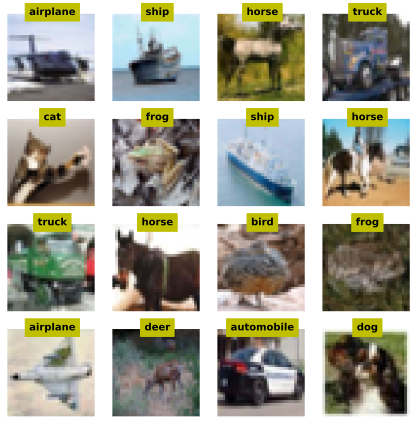

In [7]:
# inspect a few random images
X, y = next(iter(train_loader_small))

fig, axs = plt.subplots(4,4,figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + .5

    label = trainset.classes[y[i]]

    ax.imshow(pic)
    ax.text(16,0,label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create the CNN-AE model

In [8]:
def makeTheAENet(print_toggle=False):

    class aenet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            # print toggle
            self.print = print_toggle

            ### ------------------- encoding layers ---------------------- ###
            # first convolution layer
            self.enc_conv1 = nn.Conv2d(3,16,4,padding=1, stride=2) # note: using stride instead of pool to downsample
            # output size: (32 + 2*1 - 4)/2 + 1 = 16

            # second convolution layer
            self.enc_conv2 = nn.Conv2d(16,32,4,padding=1, stride=2)
            # output size: (16 + 2*1 - 4)/2 + 1 = 8

            # third convolution layer
            self.enc_conv3 = nn.Conv2d(32, 64, 4, padding=1, stride=2)
            # output size: (8 + 2*1 - 4)/2 + 1 = 4

            ### ------------------- decoding layers ---------------------- ###
            # first convolution layer
            self.dec_conv1 = nn.ConvTranspose2d(64, 32, 4, padding=1, stride=2)

            # second convolution layer
            self.dec_conv2 = nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2)

            # third convolution layer (output)
            self.dec_conv3 = nn.ConvTranspose2d(16,3, 4, padding=1, stride=2)

        def forward(self, x):

            if self.print: print(f'Input: {x.shape}')

            # first encoder block
            x = F.leaky_relu(self.enc_conv1(x))
            if self.print: print(f'First encoder block: {x.shape}')

            # second encoder block
            x = F.leaky_relu(self.enc_conv2(x))
            if self.print: print(f'Second encoder block: {x.shape}')

            # third encoder block (latent)
            x = F.leaky_relu(self.enc_conv3(x))
            if self.print: print(f'Third encoder block: {x.shape}')

            # first decoder block
            x = F.leaky_relu(self.dec_conv1(x))
            if self.print: print(f'First decoder block: {x.shape}')

            # second decoder block
            x = F.leaky_relu(self.dec_conv2(x))
            if self.print: print(f'Second decoder block: {x.shape}')

            # third decoder block (output)
            x = F.leaky_relu(self.dec_conv3(x))
            if self.print: print(f'Decoder output: {x.shape}')

            return x

    net = aenet(print_toggle)
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)

    return net, lossfunc, optimizer

In [9]:
# test the model with one batch
aenet, lossfunc, optimizer = makeTheAENet(True)

X, y = next(iter(train_loader_small))
yHat = aenet(X)
print('\nOutput size:')
print(yHat.shape)

loss = lossfunc(yHat, X)
print('\nLoss:')
print(loss)

Input: torch.Size([32, 3, 32, 32])
First encoder block: torch.Size([32, 16, 16, 16])
Second encoder block: torch.Size([32, 32, 8, 8])
Third encoder block: torch.Size([32, 64, 4, 4])
First decoder block: torch.Size([32, 32, 8, 8])
Second decoder block: torch.Size([32, 16, 16, 16])
Decoder output: torch.Size([32, 3, 32, 32])

Output size:
torch.Size([32, 3, 32, 32])

Loss:
tensor(0.2863, grad_fn=<MseLossBackward0>)


## Create a function that trains the AE model

In [10]:
def function2trainTheAEModel(net, lossfunc, optimizer):

    numepochs = 15

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []

        for X, y in train_loader_full:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        batchLoss = []

        for X, y in test_loader_full:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfunc(yHat, X)

            batchLoss.append(loss.item())

        testLoss[epochi] = np.mean(batchLoss)

    return trainLoss, testLoss, net

## Run the AE model and show the results!

In [11]:
# ~ 5 minutes with 15 epochs in GPU

netAE, lossfunc, optimizer = makeTheAENet()

trainLossAE, testLossAE, netAE = function2trainTheAEModel(netAE, lossfunc, optimizer)

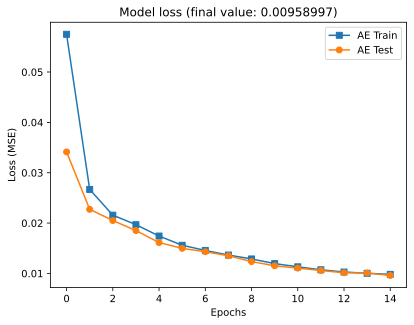

In [12]:
plt.plot(trainLossAE, 's-', label='AE Train')
plt.plot(testLossAE, 'o-', label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)' %testLossAE[-1])
plt.legend()

plt.show()

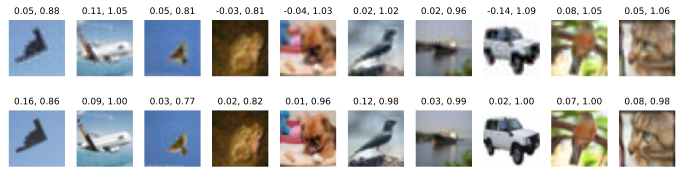

In [15]:
# show some random examples

X, y = next(iter(test_loader_small))

netAE.cpu()
netAE.eval()
yHat = netAE(X)

fig, axs = plt.subplots(2,10,figsize=(12,3))

for i in range(10):
    pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5
    axs[0,i].imshow(pic)
    axs[0,i].set_title(f'{np.min(pic):.2f}, {np.max(pic):.2f}', fontsize=9)
    axs[0,i].axis('off')

    pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5
    axs[1,i].imshow(pic)
    axs[1,i].set_title(f'{np.min(pic):.2f}, {np.max(pic):.2f}', fontsize=9)
    axs[1,i].axis('off')

plt.show()

## Now create a new model that does classification

In [16]:
def makeTheClassNet(print_toggle=False):

    class cnnnet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

             ### ------------------- encoding layers ---------------------- ###
            # first convolution layer
            self.enc_conv1 = nn.Conv2d(3,16,4,padding=1, stride=2) # note: using stride instead of pool to downsample
            # output size: (32 + 2*1 - 4)/2 + 1 = 16

            # second convolution layer
            self.enc_conv2 = nn.Conv2d(16,32,4,padding=1, stride=2)
            # output size: (16 + 2*1 - 4)/2 + 1 = 8

            # third convolution layer
            self.enc_conv3 = nn.Conv2d(32, 64, 4, padding=1, stride=2)
            # output size: (8 + 2*1 - 4)/2 + 1 = 4

            ### ------------------- linear layers ---------------------- ###
            self.fc1 = nn.Linear(4*4*64, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 10)

        def forward(self, x):

            if self.print: print(f'Input: {x.shape}')

            # first encoder block
            x = F.leaky_relu(self.enc_conv1(x))
            if self.print: print(f'First encoder block: {x.shape}')

            # second encoder block
            x = F.leaky_relu(self.enc_conv2(x))
            if self.print: print(f'Second encoder block: {x.shape}')

            # third encoder block (latent)
            x = F.leaky_relu(self.enc_conv3(x))
            if self.print: print(f'Third encoder block: {x.shape}')

            # reshape to linear
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Post-convolution vectorized: {x.shape}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            if self.print: print(f'First linear layer: {x.shape}')

            x = F.leaky_relu(self.fc2(x))
            if self.print: print(f'Second linear layer: {x.shape}')

            x = self.fc3(x)
            if self.print: print(f'Output linear layer: {x.shape}')

            return x

    net = cnnnet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

In [17]:
# test the model with one batch
tmpnet, lossfunc, optimizer = makeTheClassNet(True)

X, y = next(iter(train_loader_small))
yHat = tmpnet(X)

loss = lossfunc(yHat, y)
print('\nLoss:')
print(loss)

Input: torch.Size([32, 3, 32, 32])
First encoder block: torch.Size([32, 16, 16, 16])
Second encoder block: torch.Size([32, 32, 8, 8])
Third encoder block: torch.Size([32, 64, 4, 4])
Post-convolution vectorized: torch.Size([32, 1024])
First linear layer: torch.Size([32, 128])
Second linear layer: torch.Size([32, 64])
Output linear layer: torch.Size([32, 10])

Loss:
tensor(2.2922, grad_fn=<NllLossBackward0>)


## Now we need another function to train the classifier

In [22]:
def function2trainTheClassModel(net, lossfunc, optimizer, train_loader, test_loader):

    numepochs = 10

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = np.mean(batchAcc)

        net.eval()
        batchLoss = []
        batchAcc = []

        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfunc(yHat, y)

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        testLoss[epochi] = np.mean(batchLoss)
        testAcc[epochi] = np.mean(batchAcc)

    return trainLoss, testLoss, trainAcc, testAcc, net

In [24]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet, lossfunc, optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive, testLossNaive, trainAccNaive, testAccNaive, naivenet = function2trainTheClassModel(
    naivenet, lossfunc, optimizer, train_loader_small, test_loader_small
)

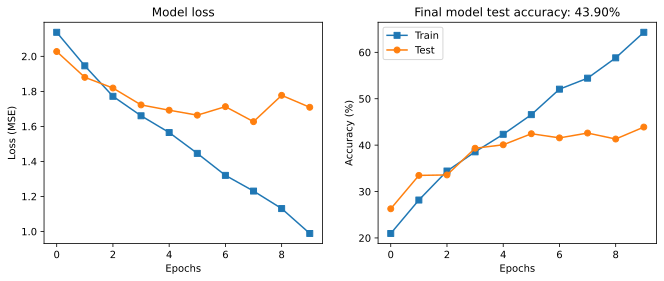

In [25]:
fig, ax = plt.subplots(1,2, figsize=(11,4))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(testLossNaive,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(testAccNaive,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAccNaive[-1]:.2f}%')
ax[1].legend()

plt.show()

## Build a new model but replace the convolution layers with AE layer

In [26]:
# create a new network (weights replaced below)
pretrainNet, lossfunc, optimizer = makeTheClassNet()

#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target, source in zip(pretrainNet.named_parameters(), aenet.named_parameters()):
    print('PRETRAIN: ' + target[0] + '      AENET: ' + source[0])

    if 'enc' in target[0]:

        # copy over the parameters...
        target[1].data = copy.deepcopy(source[1].data)

        # ... and then freeze that layer
        # target[1].requires_grad = False

PRETRAIN: enc_conv1.weight      AENET: enc_conv1.weight
PRETRAIN: enc_conv1.bias      AENET: enc_conv1.bias
PRETRAIN: enc_conv2.weight      AENET: enc_conv2.weight
PRETRAIN: enc_conv2.bias      AENET: enc_conv2.bias
PRETRAIN: enc_conv3.weight      AENET: enc_conv3.weight
PRETRAIN: enc_conv3.bias      AENET: enc_conv3.bias
PRETRAIN: fc1.weight      AENET: dec_conv1.weight
PRETRAIN: fc1.bias      AENET: dec_conv1.bias
PRETRAIN: fc2.weight      AENET: dec_conv2.weight
PRETRAIN: fc2.bias      AENET: dec_conv2.bias
PRETRAIN: fc3.weight      AENET: dec_conv3.weight
PRETRAIN: fc3.bias      AENET: dec_conv3.bias


In [27]:
# double-check that they match
pretrainNet.cpu().enc_conv1.weight[10] - aenet.enc_conv1.weight[10]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [28]:
# train the pretrained model
trainLossPre, testLossPre, trainAccPre, testAccPre, pretrainNet = function2trainTheClassModel(
    pretrainNet, lossfunc, optimizer, train_loader_small, test_loader_small
)

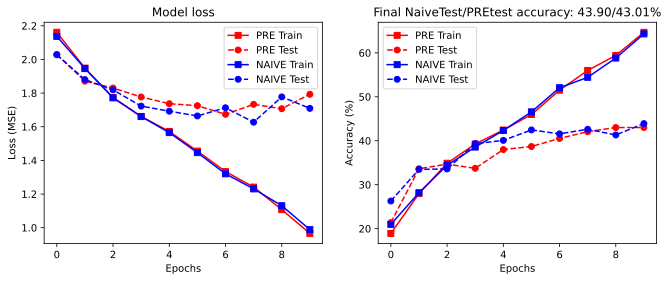

In [29]:
fig,ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(testLossPre,'ro--',label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(testLossNaive,'bo--',label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(testAccPre,'ro--',label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(testAccNaive,'bo--',label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive[-1]:.2f}/{testAccPre[-1]:.2f}%')
ax[1].legend()

plt.show()